In [9]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.transforms import Bbox


In [13]:
df = pd.read_csv("results.csv")

metric = "RMSE"
df = df[df["metric"] == metric]
#df = df[df['suite_id'] == 336]

splits = [s for s in df["split_method"].unique() if s.lower() != "random_split"]
 
method_order = [
    'ConstantPredictor', 'LinearRegressor', 'LogisticRegressor' , 'RandomForestClassifier', 'RandomForestRegressor', 'LGBMClassifier', 'LGBMRegressor',
    'Engression', 'MLP', 'ResNet', 'FTTransformer', 'DGBT', 'DRF', 'TabPFNRegressor'
]
rename_map = {
    'RandomForestClassifier': 'Random Forest',
    'RandomForestRegressor': 'Random Forest',
    'LGBMClassifier': 'Boosted Trees',
    'LGBMRegressor': 'Boosted Trees',
    'FTTransformer': 'FT-Transformer',
    'LinearRegressor': 'Linear Regression',
    'TabPFNRegressor': 'TabPFN'
}

# 3) Extract unique suites, metrics, and extrapolation methods
suites  = df['suite_id'].unique()
metrics = df['metric'].unique()
methods = df['split_method'].unique()

In [14]:
df.head()


,suite_id,task_id,split_method,model,metric,value
505,335,361093,gower_split,Engression,RMSE,0.073143
506,335,361093,umap_split,ConstantPredictor,RMSE,1.188115
507,335,361093,umap_split,LinearRegressor,RMSE,1.010513
510,335,361093,umap_split,RandomForestRegressor,RMSE,0.724389
511,335,361093,gower_split,ConstantPredictor,RMSE,0.723444


Split 'gower_split': baseline RMSE per task:
 task_id
361093      0.066522
361094      1.682160
361096      0.115570
361097      7.858750
361098      0.140371
361099      0.532168
361101      0.452992
361102      0.229836
361103      0.408299
361104      0.060397
361287      0.026459
361288      2.162013
361289    422.020573
361291      2.944008
361292      0.545782
361293      1.995108
361294      0.298026
dtype: float64
Split 'gower_split': overall lowest RMSE = 0.026458864



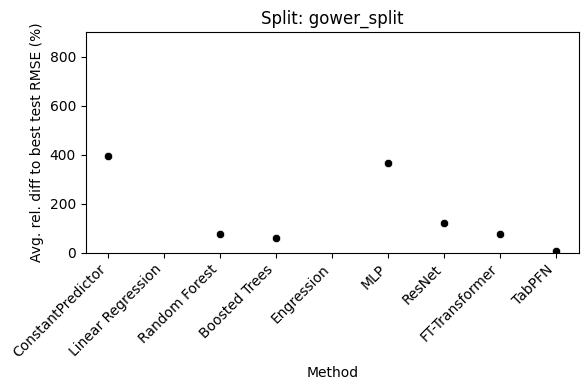

Split 'umap_split': baseline RMSE per task:
 task_id
361072      2.332328
361073      2.411298
361074      0.001957
361076      0.756206
361077      0.000155
361078      0.276103
361079      0.945192
361080      0.223418
361081      0.053354
361082      0.772213
361083      0.482896
361084      0.222978
361085      0.024647
361086      0.110846
361087      0.123848
361088      0.654768
361093      0.467485
361094      0.077845
361096      0.092770
361097      6.995714
361098      0.111078
361099      0.377538
361101      0.467330
361102      0.206911
361103      0.430165
361104      0.046736
361279      0.025029
361280      2.340429
361281      3.043610
361287      0.024070
361288      1.832053
361289    365.564645
361291      3.074705
361292      0.575311
361293      1.870397
361294      0.110846
dtype: float64
Split 'umap_split': overall lowest RMSE = 0.000154595



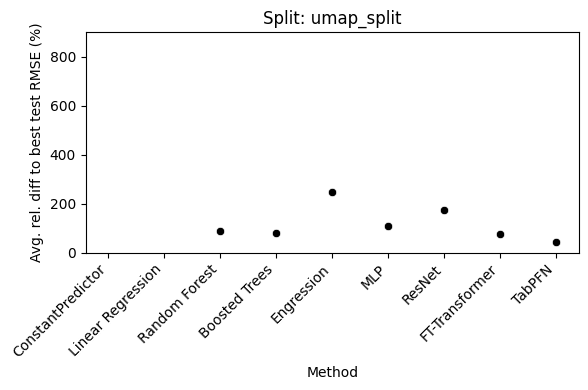

Split 'kmedoids_split': baseline RMSE per task:
 task_id
361093      0.066151
361094      2.487881
361096      0.111664
361097      8.261893
361098      0.114653
361099      0.478360
361101      0.401873
361102      0.163757
361103      0.436827
361104      0.012462
361287      0.025666
361288      2.233837
361289    404.973677
361291      2.935232
361292      0.539861
361293      1.906235
361294      0.192742
dtype: float64
Split 'kmedoids_split': overall lowest RMSE = 0.0124616



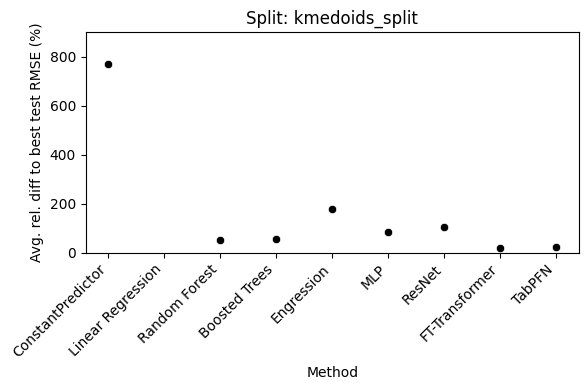

Split 'spatial_depth_split': baseline RMSE per task:
 task_id
361072    4.499054
361073    1.223352
361074    0.002486
361076    0.755450
361077    0.000216
361078    0.244689
361079    1.211294
361080    0.280927
361081    0.160078
361082    0.735151
361083    0.512270
361085    0.057449
361086    0.208819
361087    0.267862
361088    1.106089
361279    0.028219
361280    2.313366
361281    3.088980
dtype: float64
Split 'spatial_depth_split': overall lowest RMSE = 0.000216073



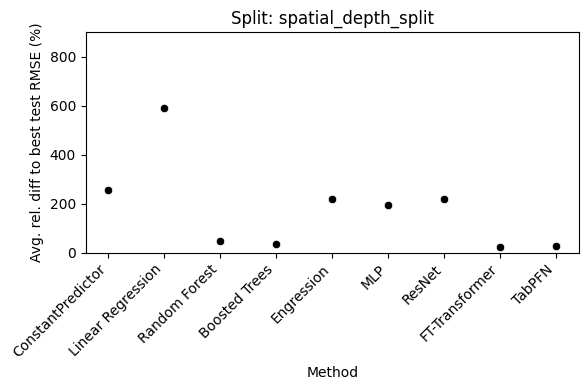

Split 'mahalanobis_split': baseline RMSE per task:
 task_id
361072    4.342733
361073    1.327924
361074    0.002313
361076    0.755014
361077    0.000217
361078    0.238430
361079    1.216632
361080    0.279980
361081    0.165416
361082    0.742261
361083    0.512406
361084    0.187371
361085    0.056785
361086    0.179392
361087    0.263375
361088    1.095788
361279    0.028242
361280    2.201527
361281    3.101494
dtype: float64
Split 'mahalanobis_split': overall lowest RMSE = 0.0002168



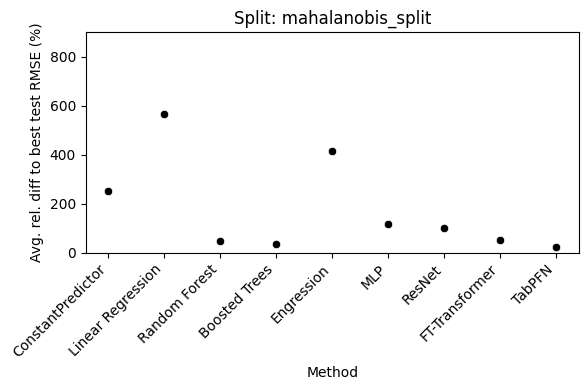

Split 'kmeans_split': baseline RMSE per task:
 task_id
361072    4.836119
361073    1.171074
361074    0.002313
361076    0.705948
361077    0.000225
361078    0.213997
361079    0.847774
361080    0.262976
361081    0.164274
361082    0.517389
361083    0.529586
361084    0.165284
361085    0.042778
361086    0.301883
361087    0.173000
361088    1.231635
361279    0.027777
361280    2.185058
361281    3.067180
dtype: float64
Split 'kmeans_split': overall lowest RMSE = 0.000225251



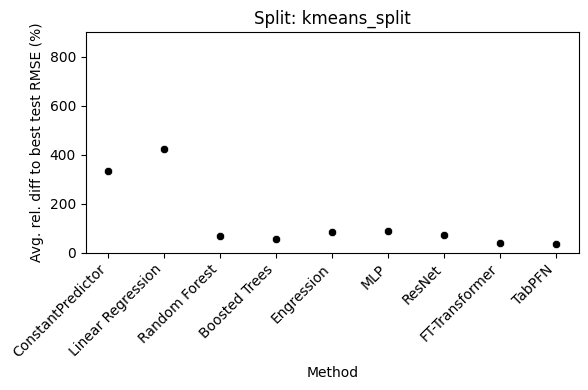

In [15]:
outdir = os.path.join('PICTURES', metric.lower())
os.makedirs(outdir, exist_ok=True)

for split in splits:
    sub = df[df["split_method"] == split]
    if sub.empty:
        continue

    table = sub.pivot(
        index="model",
        columns="task_id",
        values="value"
    )

    baseline = table.min(axis=0)
    print(f"Split '{split}': baseline RMSE per task:\n", baseline)
    print(f"Split '{split}': overall lowest RMSE = {baseline.min()}\n")

    rel = (table - baseline) / baseline

    summary = pd.DataFrame({
        "Mean": rel.mean(axis=1),
        "Median": rel.median(axis=1),
        "Std": rel.std(axis=1)
    }).reset_index().rename(columns={"model": "Method"})

    summary["Method"] = pd.Categorical(
        summary["Method"],
        categories=method_order,
        ordered=True
    )
    summary = summary.sort_values("Method")
    summary["Method"] = summary["Method"].astype(str).map(rename_map).fillna(summary["Method"].astype(str))

    summary["Mean"] = 100 * summary["Mean"]

    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=summary, x="Method", y="Mean", color='black')
    plt.xlabel("Method")
    plt.ylabel("Avg. rel. diff to best test RMSE (%)")
    plt.title(f"Split: {split}")
    plt.ylim(0, 900)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    fname = f"{split}_relative_diff_{metric}.png"
    plt.savefig(os.path.join(outdir, fname), bbox_inches='tight')
    plt.show()




In [16]:
df = df[df["metric"] == "RMSE"]

df = df[df["split_method"] != "random_split"]


=== RAW relative_difference sample ===
       split_method  task_id                  model       value    baseline  \
505     gower_split   361093             Engression    0.073143    0.066522   
506      umap_split   361093      ConstantPredictor    1.188115    0.467485   
507      umap_split   361093        LinearRegressor    1.010513    0.467485   
510      umap_split   361093  RandomForestRegressor    0.724389    0.467485   
511     gower_split   361093      ConstantPredictor    0.723444    0.066522   
512      umap_split   361093             Engression    0.937115    0.467485   
513  kmedoids_split   361093      ConstantPredictor    0.674505    0.066151   
515  kmedoids_split   361093             Engression    0.179303    0.066151   
517     gower_split   361093        LinearRegressor    0.591701    0.066522   
518      umap_split   361093          LGBMRegressor    0.586680    0.467485   
520  kmedoids_split   361093        LinearRegressor    0.498135    0.066151   
521     gowe

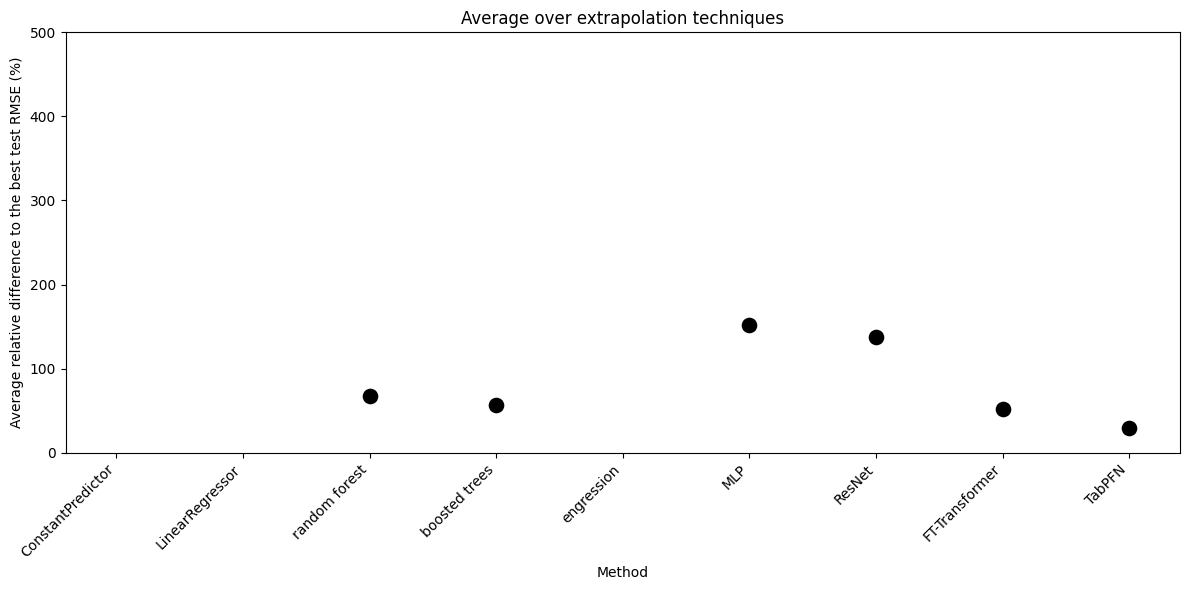

In [17]:
df["baseline"] = (
    df
    .groupby(["split_method", "task_id"])["value"]
    .transform("min")
)

df["relative_difference"] = (df["value"] - df["baseline"]) / df["baseline"]

print("\n=== RAW relative_difference sample ===")
print(df[['split_method','task_id','model','value','baseline','relative_difference']].head(20))

print("\n=== per-model relative_difference summary ===")
print(df.groupby('model')['relative_difference']
        .agg(count='count', mean='mean', min='min', max='max')
        .sort_values('mean', ascending=False)
     )

print("\n=== model appearance counts ===")
print(df.groupby('model')['relative_difference']
        .count()
        .sort_values(ascending=False)
     )


overall = (
    df
    .groupby('model')['relative_difference']
    .mean()
    .reset_index(name='Mean')
)
overall['Mean'] *= 100  

method_order = [
    'ConstantPredictor', 'LinearRegressor',
    'RandomForestClassifier', 'RandomForestRegressor',
    'LGBMClassifier', 'LGBMRegressor', 'Engression',
    'MLP', 'ResNet', 'FTTransformer', 'TabPFNRegressor'
]
overall = overall.set_index('model').reindex(method_order).reset_index()

# 3) Map to display names
rename_map = {
    'RandomForestClassifier':'random forest',
    'RandomForestRegressor':'random forest',
    'LGBMClassifier':       'boosted trees',
    'LGBMRegressor':        'boosted trees',
    'Engression':           'engression',
    'MLP':                  'MLP',
    'ResNet':               'ResNet',
    'FTTransformer':        'FT-Transformer',
    'TabPFNRegressor':      'TabPFN'
}
overall['Method'] = overall['model'].map(rename_map).fillna(overall['model'])


plt.figure(figsize=(12,6))
sns.scatterplot(data=overall, x='Method', y='Mean', color='black', s=150)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Average relative difference to the best test RMSE (%)')
plt.xlabel('Method')
plt.title('Average over extrapolation techniques')
plt.ylim(0, 500)
plt.tight_layout()

os.makedirs('PICTURES', exist_ok=True)
plt.savefig('PICTURES/average_over_extrapolation_techniques_RMSE_fixed.png', bbox_inches='tight')
plt.show()
